# JS_EDA__X_Y_LOCATION

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

import missingno as msno

import warnings
warnings.filterwarnings("ignore") 

from datetime import datetime
from IPython.display import display, Markdown

In [2]:
#Map locations and see what place value is important
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

In [3]:
for library in [pd,sns,msno]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

'pandas'  version is  1.0.5
'seaborn'  version is  0.10.1
'missingno'  version is  0.4.2


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions

In [5]:
# make a dictionary of the LOCATIONs that do have X, Y
def make_location_dict(df,location,xcol,ycol):
    location_dict = dict()
    xy_dict = dict() # empty template
    xy_dict['X'] = 0
    xy_dict['Y'] = 0

    for idx,row in df[df['X'].notnull()].iterrows():
        this_loc = row[location]

        if this_loc in location_dict.keys():
            if location_dict[this_loc]['X'] != row[xcol]:
                print(f"Same loc, new X: {this_loc}, {row[xcol]}")
            if location_dict[this_loc]['Y'] != row[ycol]:
                print(f"Same loc, new Y: {this_loc}, {row[ycol]}")                                
        else:
            location_dict[this_loc] = xy_dict.copy()
            location_dict[this_loc]['X'] = row[xcol]
            location_dict[this_loc]['Y'] = row[ycol]  
            
    return location_dict

In [6]:
def find_X(location_dict,location_string,old_x, debug=False):
    # only need to do this if the old_x is NaN
    if (math.isnan(old_x)) and (location_string in location_dict.keys()):
        newX = location_dict[location_string]['X']
        if (debug):
            print(f"Filling in X for {location_string}")
    else:
        newX = old_x
    #print(f"{location_string}  {newX},{newY}")
    return newX

def find_Y(location_dict,location_string,old_y, debug=False):
    if (math.isnan(old_y)) and (location_string in location_dict.keys()):
        newY = location_dict[location_string]['Y']
        if (debug):
            print(f"Filling in Y for {location_string}")
    else:
        newY = old_y
    #print(f"{location_string}  {newX},{newY}")
    return newY

## Load files

In [7]:
df = pd.read_csv('../data/collisions_orig.csv', parse_dates=["INCDTTM"])

In [8]:
# intersections.csv
# http://data-seattlecitygis.opendata.arcgis.com/datasets/0ea49a3a3ff54ae6af2aaae47dd680fe_5.csv?outSR={%22latestWkid%22:2926,%22wkid%22:2926}

dfi = pd.read_csv('../data/intersections.csv')

In [49]:
dfi.head(3)

,X,Y,OBJECTID,INTR_ID,GIS_XCOORD,GIS_YCOORD,COMPKEY,COMPTYPE,UNITID,SUBAREA,UNITDESC,ARTERIALCLASSCD,SIGNAL_MAINT_DIST,SIGNAL_TYPE,SHAPE_LNG,SHAPE_LAT
0,1.270709e+06,194387.955195,1,18213,1.270709e+06,194387.95532,340313,13,78852,GRDWM,4TH AVE S AND S HENDERSON N ST,0.0,,NONE,-122.329732,47.523051
1,1.282582e+06,234414.695012,2,10302,1.282582e+06,234414.69508,157936,13,32854,E,WOODROW PL E AND E GARFIELD ST,0.0,,NONE,-122.284745,47.633387
2,1.261648e+06,256226.497210,3,4716,1.261648e+06,256226.49721,37264,13,231740,BLRD,12TH AVE NW AND NW 87TH ST,0.0,,NONE,-122.371401,47.692058


In [10]:
#features_1 = ['X','Y','LOCATION','INCDATE']

In [11]:
# use the other rows of our data to make a dictionary converting LOCATION text to X, Y
self_loc_dict = make_location_dict(df,'LOCATION','X','Y') 
# investigate this one -- they are very close together on the same roadway; either is fine
# ...but there are no other lines with missing data that would used this anyway

Same loc, new X: 2ND AVE S AND S SPOKANE NR ST, -122.331939324729
Same loc, new Y: 2ND AVE S AND S SPOKANE NR ST, 47.5717239239888


In [12]:
# use the intersection data to make a dictionary converting LOCATION to X, Y
intersection_dict = make_location_dict(dfi,'UNITDESC','SHAPE_LNG','SHAPE_LAT')

In [13]:
# check number of missing X before any updates
starting_nulls = df['X'].isnull().sum()
starting_nulls

7461

### Consider dictionaries...are they both valuable?

In [14]:
only_in_self = [x for x in self_loc_dict.keys() if x not in intersection_dict.keys()]
only_in_inter = [x for x in intersection_dict.keys() if x not in self_loc_dict.keys()]
print(f"Only in self: {len(only_in_self)}, only in intersections {len(only_in_inter)}")
print(f"Overlap: {len(intersection_dict.keys())-len(only_in_inter)}")

# Note: most of the items that are only in self include "BETWEEN"

Only in self: 17157, only in intersections 7662
Overlap: 7779


### Update X, Y based on other examples in the collisions.csv

In [15]:
df['X'] = df.apply(lambda x: find_X(self_loc_dict,x['LOCATION'],x['X'],debug=True), axis=1)
df['Y'] = df.apply(lambda x: find_Y(self_loc_dict,x['LOCATION'],x['Y']), axis=1)
# Only solves 4

Filling in X for 6TH AVE N AND MERCER ST
Filling in X for 5TH AVE AND MARION ST
Filling in X for 5TH AVE AND MARION ST
Filling in X for 6TH AVE N AND MERCER ST


In [16]:
# check number of missing X after intersection update
df['X'].isnull().sum()

7457

### Update X, Y based on intersections.csv

In [17]:
# update based on intersection file
df['X'] = df.apply(lambda x: find_X(intersection_dict,x['LOCATION'],x['X']), axis=1)
df['Y'] = df.apply(lambda x: find_Y(intersection_dict,x['LOCATION'],x['Y']), axis=1)

In [18]:
# check number of missing X after intersection update
current_nulls = df['X'].isnull().sum()
print(f"Starting nulls {starting_nulls} --> current nulls {current_nulls} meaning {starting_nulls-current_nulls} resolved")

Starting nulls 7461 --> current nulls 7269 meaning 192 resolved


In [45]:
# Are there common themes in the ones that are still missing?
missing_list = df.loc[df['X'].isnull(),'LOCATION'].value_counts()
missing_list[:25] # look at the top 10

BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N                298
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB                291
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP      256
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP    230
ALASKAN WY VI NB BETWEEN SENECA ST OFF RP AND WESTERN AV OFF RP               176
ALASKAN WY VI SB BETWEEN ELLIOTT AV ON RP AND COLUMBIA ST ON RP               122
1ST AVE S BETWEEN 1ST AVS ON N RP AND S ROYAL BROUGHAM WAY                     95
AURORA AVE N BETWEEN BATTERY ST TUNNEL NB AND THOMAS ST                        95
RAINIER AVE S BETWEEN CORNELL AVE S AND 75TH AVE S                             60
BATTERY ST TUN ON RP BETWEEN BELL ST AND ALASKAN WY VI NB                      53
RAINIER AVE S BETWEEN S STEVENS ST AND M L KING JR WAY S                       48
ALASKAN WY VI NB BETWEEN BATTERY ST TUN ON RP AND WESTERN AV OFF RP            44
WESTERN AV OFF R

In [20]:
# Might be worthwhile to just manually identify the top 10 or so
missing_dict = {
    ['BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N']:{['X':],['Y':]}
               }

## Plot the X, Y that we have

In [21]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [22]:
df_good = df.loc[df['X'].notnull(),['X','Y','FATALITIES']]
df_good.shape

(213167, 3)

In [23]:
lon_list = list(df_good['X'])
type(lon_list)

list

In [24]:
lat_list = list(df_good['Y'])

In [25]:
color_code = list(df_good['FATALITIES'])

360

In [50]:
df[df['FATALITIES'] > 1].head(3)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
1926,-122.337486,47.589746,1927,47800,47800,1795308,Matched,Block,NaN,ALASKAN WY VI SB BETWEEN ALASKAN WY VI SB EFR ...,NaN,NaN,3,Fatality Collision,Other,5,0,0,1,3,0,2,2005/04/10 00:00:00+00,2005-04-10 21:51:00,Mid-Block (not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,1,Raining,Wet,Dark - Street Lights On,NaN,5100001.0,NaN,50,Fixed object,0,0,N
21139,-122.317421,47.679821,21140,33991,33991,2185203,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 70TH ST AND NE 71S...,NaN,NaN,3,Fatality Collision,Other,6,0,0,2,3,1,2,2005/11/10 00:00:00+00,2005-11-10 23:23:00,Mid-Block (not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,0,Clear,Dry,Dark - Street Lights On,NaN,5314002.0,Y,50,Fixed object,0,0,N
39397,-122.389458,47.594064,39398,52666,52666,2620264,Matched,Block,NaN,ALKI AVE SW BETWEEN SW RHODE ISLAND ST AND SW ...,,NaN,3,Fatality Collision,Other,6,0,0,1,4,1,2,2006/09/24 00:00:00+00,2006-09-24 05:13:00,Mid-Block (not related to intersection),27.0,MOTOR VEHICLE RAN OFF ROAD - NO COLLISION,NaN,1,Clear,Dry,Dark - Street Lights On,NaN,6267001.0,Y,50,Fixed object,0,0,N


In [47]:
def draw_map(df,color_col):
    '''
    df - main dataframe
    color - which column to use for color
    '''
    
    # 1. Set up the base map -- zoom region, projection, resolution

    
    # setting up the zoom -- here's the whole world
    m_llcrnrlon = -180
    m_llcrnrlat = -90
    m_urcrnrlon = 180
    m_urcrnrlat = 90   
    
    # try calculating zoom
    if (1):
        border = .005 # 0.01 looks good
        m_llcrnrlat = min(df['Y']) - border
        m_urcrnrlat = max(df['Y']) + border
        m_llcrnrlon = min(df['X']) - border
        m_urcrnrlon = max(df['X']) + border
        
    # print(f"{m_llcrnrlat} {m_llcrnrlon} {m_urcrnrlon} {m_urcrnrlat}")    # for debug
        
        
    # started with 'cyl'
    # try 'mill' for miller and add resolution
    
    
    # resolution can be ``c`` (crude), ``l`` (low), ``i`` (intermediate), 
    #   ``h``(high), ``f`` (full) or None.
    set_res = 'f'
    
    
    _ = map_plotter = Basemap(projection='cyl',\
                                 llcrnrlon = m_llcrnrlon,\
                                 llcrnrlat = m_llcrnrlat,\
                                 urcrnrlon = m_urcrnrlon,\
                                 urcrnrlat = m_urcrnrlat,\
                                 resolution=set_res) ;
    
    plt.figure(figsize=(20, 20));
    #map_plotter.shadedrelief()   # appears to be insufficient detail for city level
    #map_plotter.bluemarble()     # appears to be insufficient detail for city level
    
    
    # 2. Add the data points, doing them in groups for greater efficiency
    #lon_list_0 = list(df_good['X'])   
    
    color_codes = sorted(list(df[color_col].unique()))
    
    # initial approach - plot everything with red x
    #map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=10);
    
    color_list = ['green','blue','red','red','red','violet']
    
    for idx in range(0,len(color_codes)):
        lon_list = df.loc[df['X'].notnull() & df[color_col] == color_codes[idx],'X']
        lat_list = df.loc[df['Y'].notnull() & df[color_col] == color_codes[idx],'Y']
        
        color = color_list[idx]
        _ = map_plotter.scatter(lon_list,lat_list,latlon=True, c=color, 
                                marker = 'x',s=5*idx+10);

    ax = plt.gca()
    
    title = "Collision X,Y"

    plt.title(title);

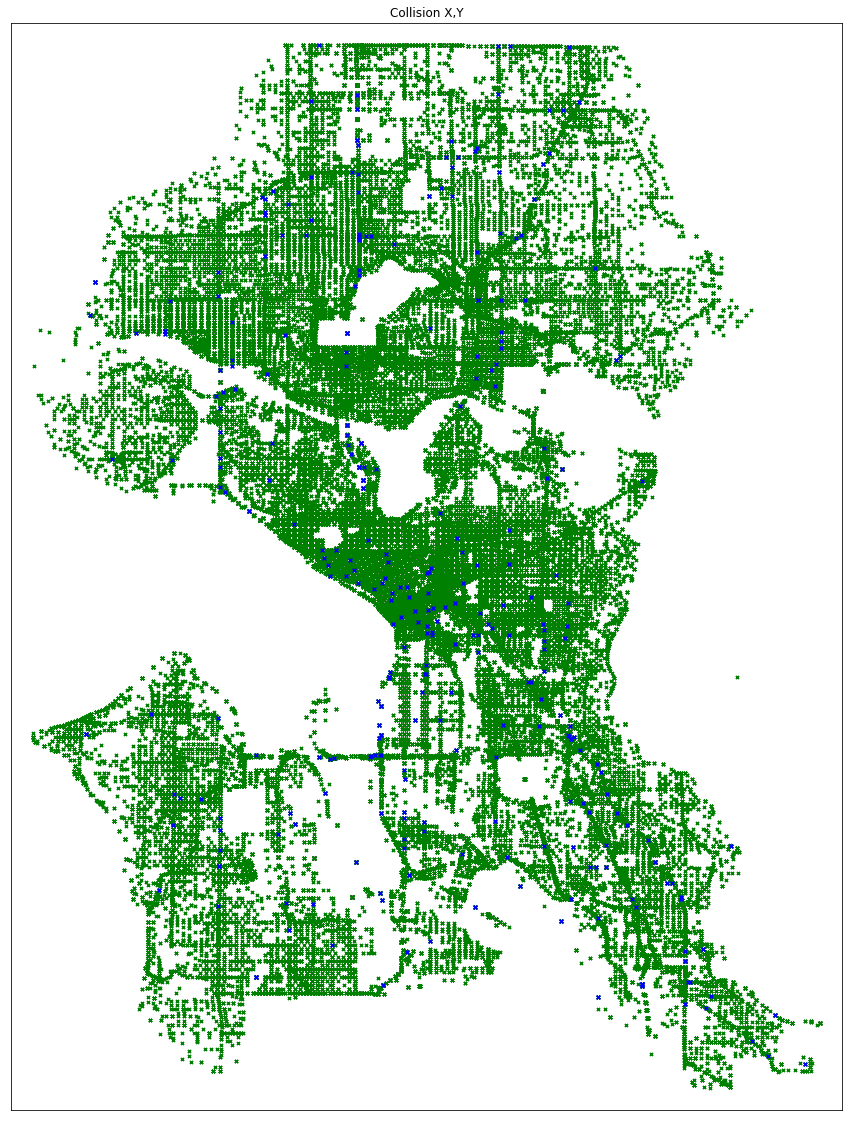

In [48]:
draw_map(df,'FATALITIES')

## Considering detail level we need for X, Y

In [ ]:
def convert_degrees_to_feet(n_deg):
    return (n_deg * 10000 * 3280.4 / 90)

In [ ]:
convert_degrees_to_feet(1)  # 1 degree is 364 feet

In [ ]:
convert_degrees_to_feet(-104.673) # DIA example from https://sciencing.com/convert-latitude-longtitude-feet-2724.html

In [ ]:
convert_degrees_to_feet(.01)  # .01 degree is 3644 feet

In [ ]:
convert_degrees_to_feet(.00001)  # .00001 degree is 3.644 feet -- this is more than enough precision!

In [ ]:
# Round the X,Y to 5 decimal places 
np.round(3.644888888888889,5)

In [ ]:
df['X'] = df['X'].apply(lambda x: np.round(x,5))

In [ ]:
df['X'].head()

In [ ]:
df['Y'] = df['Y'].apply(lambda x: np.round(x,5))

In [ ]:
df.groupby(['LOCATION','X','Y'])[['LOCATION','X','Y']].count()

# What do these mean in terms of distance?

10TH AVE AND E PIKE ST	-122.31945	47.61409	25	25	25     


10TH AVE AND E PINE ST	-122.31947	47.61525	23	23	23

In [ ]:
convert_degrees_to_feet(47.61525 - 47.61409) # 422 feet

In [ ]:
convert_degrees_to_feet(-122.31945 - -122.31947)

In [ ]:
# Look for all entries in original data that include 10TH AVE AND E PIKE ST
df_10pike = df[df['LOCATION'] == '10TH AVE AND E PIKE ST'].copy()

In [ ]:
df_10pike[['X','Y','LOCATION','ADDRTYPE','INCDATE','JUNCTIONTYPE']].count()

In [ ]:
# Spokane street oddity
convert_degrees_to_feet(-122.33094 - -122.33194) 
# 364 foot -- looked at Google Earth -- they are near each other on same roadway; nearest intersection is correct
#    no need to adjust since there are no other uses of this text LOCATION string